In [1]:
import pandas as pd
import torch
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
data_df = pd.read_csv("pingumil/experiments/sswinpred/embeddings/embedding_dict.csv", index_col=0)
#print(data_df)

player1_embs = None
player2_embs = None
with open("pingumil/experiments/sswinpred/embeddings/player1embs.pt", "rb") as fp:
    player1_embs = torch.load(fp)
with open("pingumil/experiments/sswinpred/embeddings/player2embs.pt", "rb") as fp:
    player2_embs = torch.load(fp)

In [3]:
assert len(data_df.index) == player1_embs.shape[0]
assert len(data_df.index) == player2_embs.shape[0]

In [4]:
all_embs = torch.concat((player1_embs, player2_embs)).cpu()
print(all_embs.shape)

torch.Size([12834, 128])


GENERAL CLUSTERING

In [5]:
def plot_clustering(embeds, labels, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embeds[:,0],embeds[:,1],embeds[:,2], marker="s", c=labels, s=10, alpha=.1, cmap="tab20b")
    #ax.set_xlim3d(-0.6, 0.6)
    #ax.set_ylim3d(-0.6, 0.6)
    #ax.set_zlim3d(-0.6, 0.6)
    leghandles, leglabels = scatter.legend_elements()
    for l in leghandles:
        l.set_alpha(1)
    legend1 = ax.legend(leghandles, leglabels,
                        loc="upper right", title=title)
    ax.add_artist(legend1)
    plt.tight_layout()
    plt.show()

In [6]:
pca = PCA(n_components=3)

In [11]:
pca_embeds = pca.fit_transform(all_embs)

K-MEANS

In [22]:
def get_kmeans(embeds, n):
    best_km = None
    best_labels_score = -1
    patience = 25
    for k in range(100):
        if k%10==0:
            print(f"Current step: {k}")
        km = KMeans(n_clusters=n).fit(embeds)
        score = silhouette_score(embeds, km.labels_, sample_size=1000)
        if score > best_labels_score:
            best_labels_score = score
            best_km = km
            patience = 10
        else:
            patience = patience - 1
        if patience == 0:
            break
    return best_km, best_labels_score

In [23]:
km, best_km_score = get_kmeans(all_embs, 5)

Current step: 0
Current step: 10


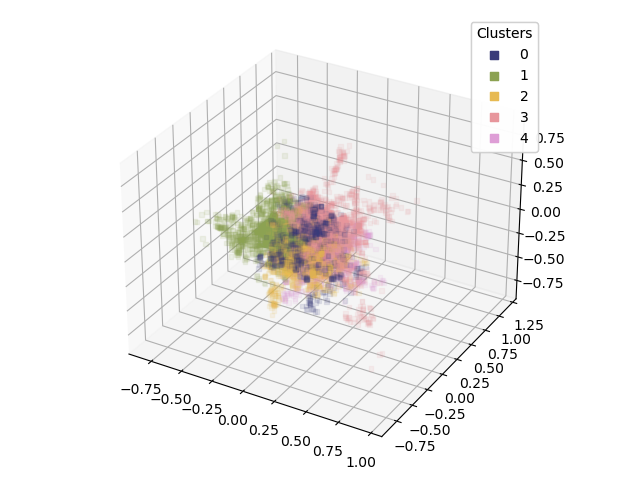

In [25]:
plot_clustering(pca_embeds, km.labels_, "Clusters")

In [26]:
player1_labels = km.predict(player1_embs.cpu())
print(player1_labels)
unique, counts = np.unique(player1_labels, return_counts=True)
print(dict(zip(unique, counts)))

player2_labels = km.predict(player2_embs.cpu())
print(player2_labels)
unique, counts = np.unique(player2_labels, return_counts=True)
print(dict(zip(unique, counts)))

[3 3 3 ... 0 0 0]
{0: 548, 1: 1162, 2: 1257, 3: 2697, 4: 753}
[3 3 3 ... 2 0 0]
{0: 549, 1: 1127, 2: 1269, 3: 2700, 4: 772}


In [28]:
kmeans_datadf = data_df.copy()
print(kmeans_datadf)
kmeans_datadf["player01_cluster"] = player1_labels
kmeans_datadf["player02_cluster"] = player2_labels

      timestamp                                              graph
0            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
1            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
2            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
3            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
4            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
...         ...                                                ...
6412        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
6413        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
6414        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
6415        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
6416        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...

[6417 rows x 2 columns]


In [30]:
print(kmeans_datadf)
kmeans_datadf.to_csv("player_profiles_sswinpred.csv")

      timestamp                                              graph  \
0            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
1            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
2            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
3            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
4            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
...         ...                                                ...   
6412        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
6413        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
6414        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
6415        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   
6416        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...   

      player01_cluster  player02_cluster  
0                    3                 3  
1                    3                 3  
2                    3        

Spectral Clustering

In [25]:
def get_spectral(embeds, n):
    spectral = SpectralClustering(n_clusters=n, n_init=20, gamma=0.55, assign_labels='discretize').fit(embeds)
    return spectral

In [37]:
k=20
spectral = get_spectral(all_embs, k)

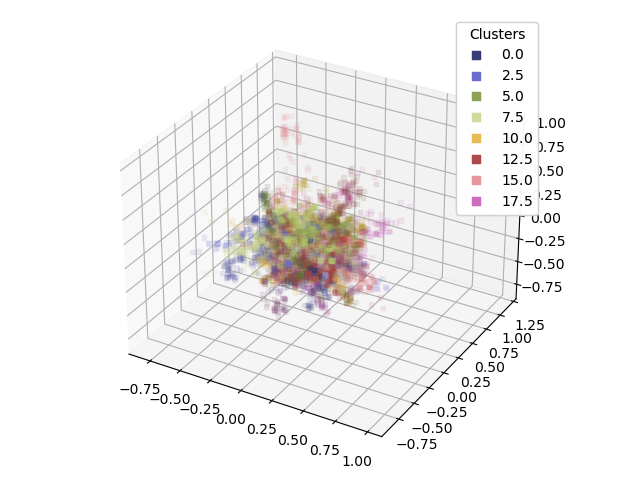

In [38]:
plot_clustering(pca_embeds, spectral.labels_, "Clusters")

In [39]:
unique, counts = np.unique(spectral.labels_, return_counts=True)
print(dict(zip(unique, counts)))

{0: 787, 1: 873, 2: 1162, 3: 94, 4: 390, 5: 837, 6: 1203, 7: 925, 8: 926, 9: 781, 10: 623, 11: 490, 12: 1055, 13: 807, 14: 122, 15: 149, 16: 85, 17: 441, 18: 572, 19: 512}


In [40]:
player1_labels = spectral.labels_[:len(player1_embs.cpu())]
print(player1_labels)
unique, counts = np.unique(player1_labels, return_counts=True)
print(dict(zip(unique, counts)))

player2_labels = spectral.labels_[len(player1_embs.cpu()):]
print(player2_labels)
unique, counts = np.unique(player2_labels, return_counts=True)
print(dict(zip(unique, counts)))

spectral_datadf = data_df.copy()
print(spectral_datadf)
spectral_datadf["player01_cluster"] = player1_labels
spectral_datadf["player02_cluster"] = player2_labels

spectral_datadf.to_csv(f"player_profiles_sswinpred_spectralg55k{k}.csv")

[ 0  0  0 ... 16 16 16]
{0: 396, 1: 449, 2: 582, 3: 48, 4: 199, 5: 410, 6: 609, 7: 472, 8: 453, 9: 386, 10: 312, 11: 239, 12: 519, 13: 401, 14: 62, 15: 74, 16: 46, 17: 218, 18: 284, 19: 258}
[ 0  0  0 ... 16 16 16]
{0: 391, 1: 424, 2: 580, 3: 46, 4: 191, 5: 427, 6: 594, 7: 453, 8: 473, 9: 395, 10: 311, 11: 251, 12: 536, 13: 406, 14: 60, 15: 75, 16: 39, 17: 223, 18: 288, 19: 254}
      timestamp                                              graph
0            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
1            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
2            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
3            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
4            20  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
...         ...                                                ...
6412        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
6413        480  /raid/home/smelo/PingUMiL-pytorch/dataset/Smok...
6414        480